In [1]:
# =============================================================================
#
# FLIGHT OPERATIONS ANALYSIS & DIFFICULTY SCORING
#
# =============================================================================
#
# --- PHASE 1: BUSINESS UNDERSTANDING ---
#
# GOAL: The primary goal is to analyze flight operations data to identify
# patterns, understand the drivers of operational complexity, and develop a
# "Flight Difficulty Score". This score will help in proactively managing
# resources for flights that are likely to be challenging.
#
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans # Import KMeans

print("--- Initializing Analysis ---")


--- Initializing Analysis ---


In [2]:
# =============================================================================
# --- PHASE 2: DATA UNDERSTANDING ---
# =============================================================================

try:
    print("\n[Phase 2/6] Loading datasets...")
    flight_df = pd.read_csv('Flight Level Data.csv')
    pnr_flight_df = pd.read_csv('PNR+Flight+Level+Data.csv')
    pnr_remark_df = pd.read_csv('PNR Remark Level Data.csv')
    bag_df = pd.read_csv('Bag+Level+Data.csv')
    airports_df = pd.read_csv('Airports Data.csv')
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"\nError loading files: {e}.")
    print("Please ensure all 5 CSV files are in the same directory as this script.")
    exit()



[Phase 2/6] Loading datasets...
All data files loaded successfully.


In [3]:

# =============================================================================
# --- PHASE 3: DATA PREPARATION ---
# =============================================================================

print("\n[Phase 3/6] Preparing and engineering features from data...")

# Convert date/time columns
for df_loop in [flight_df, pnr_flight_df, bag_df]:
    for col in df_loop.columns:
        if 'date' in col:
            df_loop[col] = pd.to_datetime(df_loop[col], errors='coerce')
for col in ['scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local', 'actual_departure_datetime_local', 'actual_arrival_datetime_local']:
    flight_df[col] = pd.to_datetime(flight_df[col], errors='coerce')

# Define a unique flight identifier
flight_identifier = ['company_id', 'flight_number', 'scheduled_departure_date_local']

# a) Engineer core flight features
flight_df['departure_delay'] = (flight_df['actual_departure_datetime_local'] - flight_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_df['ground_time_pressure'] = flight_df['minimum_turn_minutes'] - flight_df['scheduled_ground_time_minutes']
flight_df['scheduled_flight_duration'] = (flight_df['scheduled_arrival_datetime_local'] - flight_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60

# b) Aggregate PNR, SSR, and Bag data
pnr_agg = pnr_flight_df.groupby(flight_identifier).agg(
    total_pax=('total_pax', 'sum'),
    children_count=('is_child', lambda x: (x == 'Y').sum()),
    lap_child_count=('lap_child_count', 'sum')
).reset_index()

pnr_remark_df['pnr_creation_date'] = pd.to_datetime(pnr_remark_df['pnr_creation_date'])
pnr_flight_df_dates = pnr_flight_df[flight_identifier + ['record_locator', 'pnr_creation_date']].drop_duplicates()
ssr_merged = pd.merge(pnr_remark_df, pnr_flight_df_dates, on=['record_locator', 'pnr_creation_date', 'flight_number'])
ssr_agg = ssr_merged.groupby(flight_identifier).size().reset_index(name='ssr_count')

bag_counts = bag_df.groupby(flight_identifier + ['bag_type']).size().unstack(fill_value=0).reset_index()
if 'Origin' not in bag_counts.columns: bag_counts['Origin'] = 0
if 'Transfer' not in bag_counts.columns: bag_counts['Transfer'] = 0
bag_counts.rename(columns={'Origin': 'checked_bags', 'Transfer': 'transfer_bags'}, inplace=True)

# c) Merge into a master DataFrame
df = pd.merge(flight_df, pnr_agg, on=flight_identifier, how='left')
df = pd.merge(df, ssr_agg, on=flight_identifier, how='left')
df = pd.merge(df, bag_counts, on=flight_identifier, how='left')

# d) Handle nulls and create final features
for col in ['total_pax', 'children_count', 'lap_child_count', 'ssr_count', 'checked_bags', 'transfer_bags']:
    df[col].fillna(0, inplace=True)
df.dropna(subset=['departure_delay', 'total_seats'], inplace=True)
df = df[df['total_seats'] > 0]
df['load_factor'] = df['total_pax'] / df['total_seats']
df.loc[df['load_factor'] > 1, 'load_factor'] = 1
df['transfer_bag_ratio'] = df['transfer_bags'] / (df['checked_bags'] + df['transfer_bags']).replace(0, 1)

print("Preprocessing complete. Master analysis DataFrame created.")




[Phase 3/6] Preparing and engineering features from data...
Preprocessing complete. Master analysis DataFrame created.


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_1500\3978275141.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)



[Phase 4/6] Answering EDA Questions and Building Difficulty Score...

--- EDA Insights ---
1. Average Delay: 47.06 minutes for late flights.
   Percentage of Late Flights: 49.61%
2. Flights with Tight Schedules: 652 flights have ground time at or below the minimum.
3. Bag Ratio: The average ratio of transfer to checked bags is 3.04.
4. Load Factor vs. Delay: The correlation is -0.17, indicating a very weak relationship.
5. SSRs vs. Delay: The p-value for SSRs is 0.00, which is not statistically significant.

Using K-Means to determine difficulty classes...
K-Means classification and daily ranking complete.


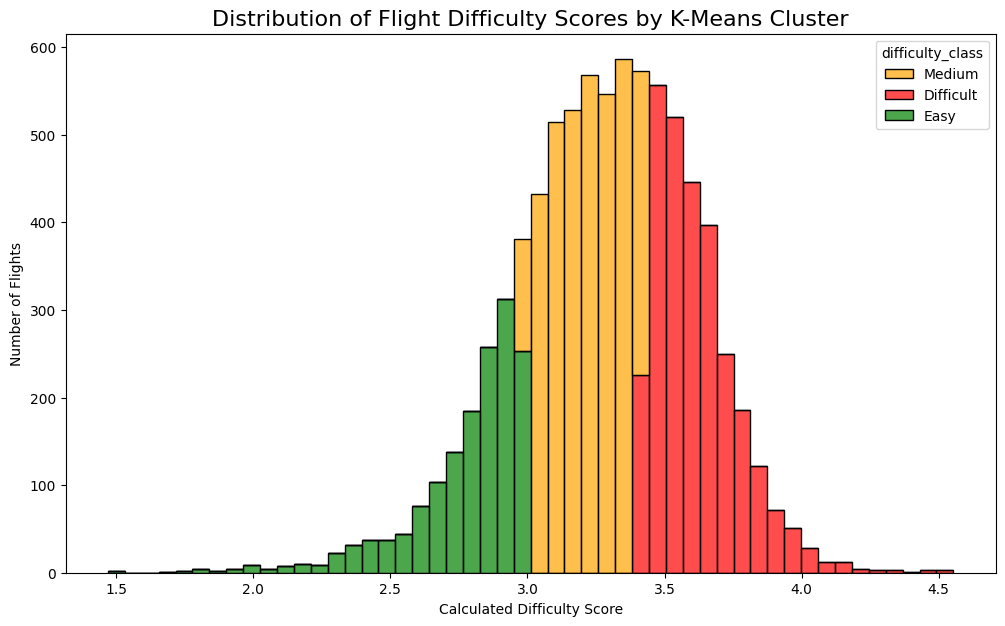

In [4]:

# =============================================================================
# --- PHASE 4: MODELING (EDA & Difficulty Score) ---
# =============================================================================

print("\n[Phase 4/6] Answering EDA Questions and Building Difficulty Score...")

# --- DELIVERABLE 1: EXPLORATORY DATA ANALYSIS ---
print("\n--- EDA Insights ---")
delayed_flights = df[df['departure_delay'] > 0]
print(f"1. Average Delay: {delayed_flights['departure_delay'].mean():.2f} minutes for late flights.")
print(f"   Percentage of Late Flights: {(len(delayed_flights) / len(df) * 100):.2f}%")
tight_schedule_flights = df[df['ground_time_pressure'] >= 0]
print(f"2. Flights with Tight Schedules: {len(tight_schedule_flights)} flights have ground time at or below the minimum.")
bag_ratio_df = df[df['checked_bags'] > 0].copy()
bag_ratio_df['ratio'] = bag_ratio_df['transfer_bags'] / bag_ratio_df['checked_bags']
print(f"3. Bag Ratio: The average ratio of transfer to checked bags is {bag_ratio_df['ratio'].mean():.2f}.")
correlation = df['load_factor'].corr(df['departure_delay'])
print(f"4. Load Factor vs. Delay: The correlation is {correlation:.2f}, indicating a very weak relationship.")
analysis_df = df[['departure_delay', 'load_factor', 'ssr_count']].dropna()
X = sm.add_constant(analysis_df[['load_factor', 'ssr_count']])
model = sm.OLS(analysis_df['departure_delay'], X).fit()
print(f"5. SSRs vs. Delay: The p-value for SSRs is {model.pvalues['ssr_count']:.2f}, which is not statistically significant.")

# --- DELIVERABLE 2: FLIGHT DIFFICULTY SCORE DEVELOPMENT ---
difficulty_features = {
    'load_factor': 1,
    'ssr_count': 1.5,
    'transfer_bag_ratio': 1.2,
    'children_count': 0.8,
    'ground_time_pressure': 1.5
}
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[list(difficulty_features.keys())] = scaler.fit_transform(df[list(difficulty_features.keys())])
df['difficulty_score'] = 0
for feature, weight in difficulty_features.items():
    df['difficulty_score'] += df_normalized[feature] * weight

# --- MODIFIED: Use K-Means Clustering for Classification ---
print("\nUsing K-Means to determine difficulty classes...")
# Reshape score for clustering
difficulty_scores_reshaped = df[['difficulty_score']].values

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(difficulty_scores_reshaped)

# Find the mean score for each cluster to label them correctly
cluster_means = df.groupby('cluster')['difficulty_score'].mean().sort_values()
difficulty_mapping = {
    cluster_means.index[0]: 'Easy',
    cluster_means.index[1]: 'Medium',
    cluster_means.index[2]: 'Difficult'
}
df['difficulty_class'] = df['cluster'].map(difficulty_mapping)

# Rank flights within each day
df['daily_rank'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(method='first', ascending=False)
print("K-Means classification and daily ranking complete.")

# --- NEW VISUALIZATION: Show Cluster Separation ---
plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='difficulty_score', hue='difficulty_class',
             palette={'Easy': 'green', 'Medium': 'orange', 'Difficult': 'red'},
             bins=50, alpha=0.7, multiple="stack")
plt.title('Distribution of Flight Difficulty Scores by K-Means Cluster', fontsize=16)
plt.xlabel('Calculated Difficulty Score')
plt.ylabel('Number of Flights')
plt.show()




[Phase 5/6] Evaluating the Difficulty Score...


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_1500\1236660516.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='difficulty_class', y='departure_delay',


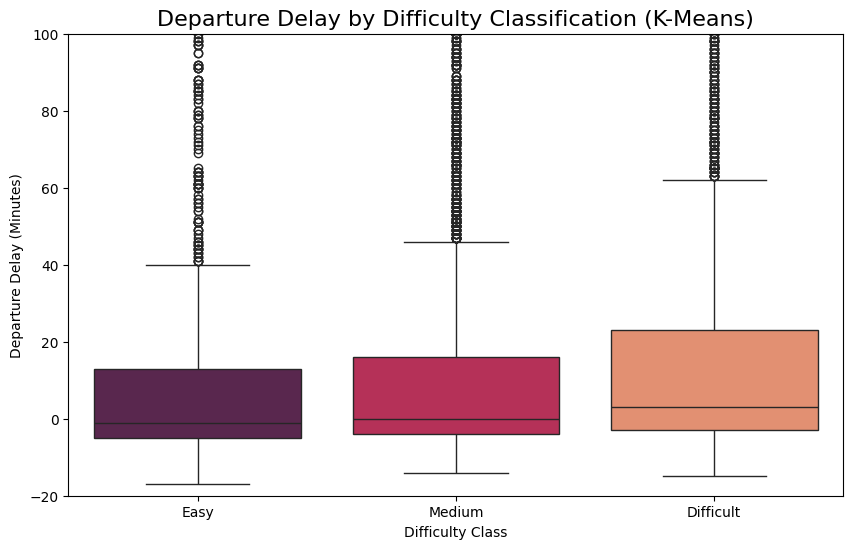

In [5]:

# =============================================================================
# --- PHASE 5: EVALUATION ---
# =============================================================================

print("\n[Phase 5/6] Evaluating the Difficulty Score...")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='difficulty_class', y='departure_delay',
            order=['Easy', 'Medium', 'Difficult'], palette='rocket')
plt.title('Departure Delay by Difficulty Classification (K-Means)', fontsize=16)
plt.xlabel('Difficulty Class')
plt.ylabel('Departure Delay (Minutes)')
plt.ylim(-20, 100)
plt.show()



Displaying new cluster visualizations...


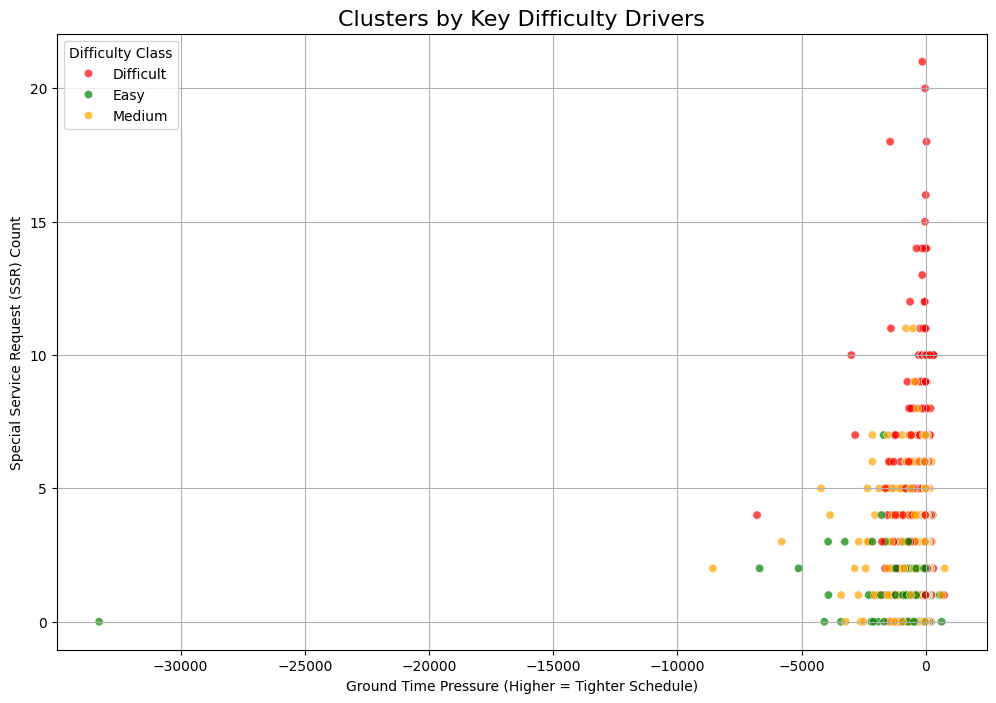

In [6]:
# 1. Scatter Plot of Key Drivers by Cluster
print("Displaying new cluster visualizations...")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df.sample(5000, random_state=42), # Use a sample for clarity
                x='ground_time_pressure',
                y='ssr_count',
                hue='difficulty_class',
                palette={'Easy': 'green', 'Medium': 'orange', 'Difficult': 'red'},
                alpha=0.7)
plt.title('Clusters by Key Difficulty Drivers', fontsize=16)
plt.xlabel('Ground Time Pressure (Higher = Tighter Schedule)')
plt.ylabel('Special Service Request (SSR) Count')
plt.legend(title='Difficulty Class')
plt.grid(True)
plt.show()


Generating a pair plot to show multi-dimensional cluster separation...


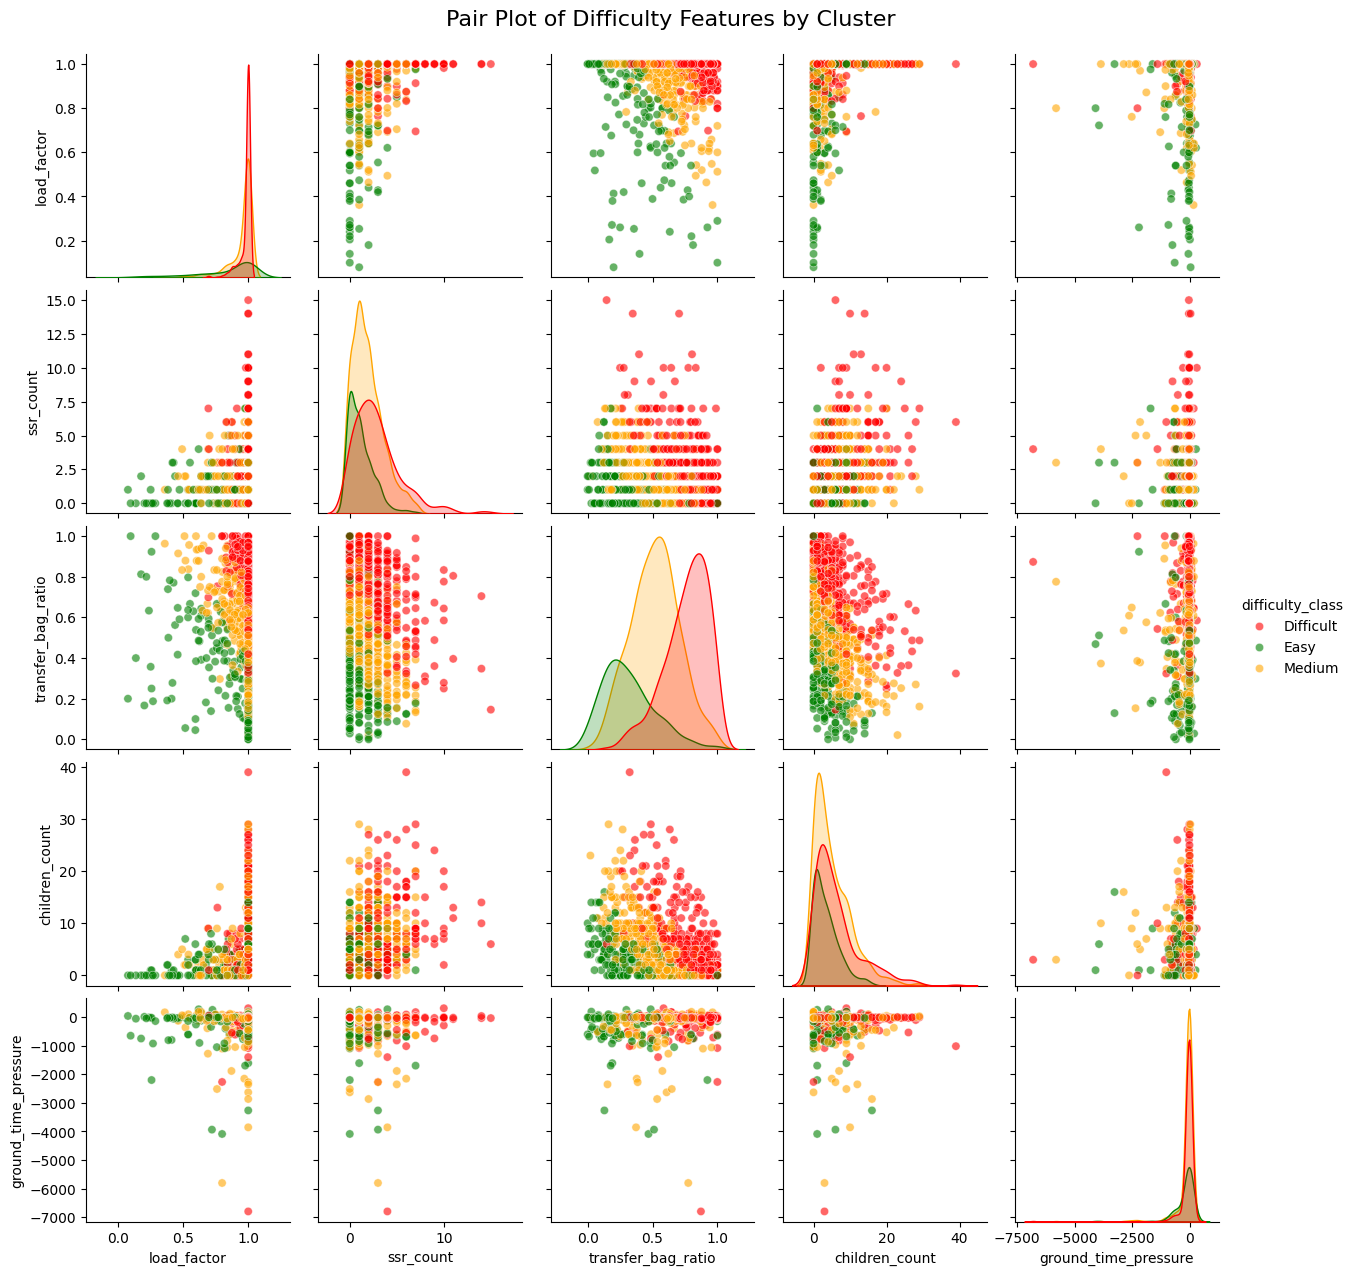

In [7]:

# 2. Pair Plot of All Difficulty Features by Cluster
print("Generating a pair plot to show multi-dimensional cluster separation...")
pairplot_features = list(difficulty_features.keys()) + ['difficulty_class']
# Use a smaller sample for the pairplot as it can be computationally intensive
pairplot_sample = df[pairplot_features].sample(n=min(1000, len(df)), random_state=42)
sns.pairplot(pairplot_sample, hue='difficulty_class',
             palette={'Easy': 'green', 'Medium': 'orange', 'Difficult': 'red'},
             plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot of Difficulty Features by Cluster', y=1.02, fontsize=16)
plt.show()


In [8]:

# =============================================================================
# --- PHASE 6: DEPLOYMENT (INSIGHTS) ---
# =============================================================================

print("\n[Phase 6/6] Generating Final Insights and Recommendations...")
print("\n--- Operational Insights ---")



[Phase 6/6] Generating Final Insights and Recommendations...

--- Operational Insights ---


In [9]:

# a) Summarize difficult destinations
difficult_flights = df[df['difficulty_class'] == 'Difficult']
top_difficult_destinations = difficult_flights['scheduled_arrival_station_code'].value_counts().nlargest(5)
print("1. Top 5 Most Consistently Difficult Destinations (based on clustering):")
print(top_difficult_destinations)


1. Top 5 Most Consistently Difficult Destinations (based on clustering):
scheduled_arrival_station_code
STL    85
GRR    72
MSN    65
CLE    57
OMA    56
Name: count, dtype: int64


In [10]:

# b) Analyze common drivers
top_dest_drivers = difficult_flights[difficult_flights['scheduled_arrival_station_code'].isin(top_difficult_destinations.index)]
driver_analysis = top_dest_drivers.groupby('scheduled_arrival_station_code')[list(difficulty_features.keys())].mean()
print("\n2. Common Drivers for Top Difficult Destinations (Average Values):")
print(driver_analysis.round(2))



2. Common Drivers for Top Difficult Destinations (Average Values):
                                load_factor  ssr_count  transfer_bag_ratio  \
scheduled_arrival_station_code                                               
CLE                                    0.98       3.28                0.74   
GRR                                    0.95       1.76                0.92   
MSN                                    0.96       1.38                0.94   
OMA                                    0.98       2.18                0.80   
STL                                    0.99       1.84                0.87   

                                children_count  ground_time_pressure  
scheduled_arrival_station_code                                        
CLE                                       6.16                -78.82  
GRR                                       2.86               -175.49  
MSN                                       2.08                -93.85  
OMA                           

In [11]:

# c) Recommendations
print("\n3. Recommendations for Better Operational Efficiency:")
print("   - Proactive Resource Allocation: Use the daily 'Difficult' classification from the clustering model to pre-allocate staff for flights to top difficult destinations.")
print("   - Targeted SSR Support: High SSR counts remain a key complexity driver. An alert system for the gate manager on these flights could streamline boarding.")
print("   - Baggage Hotspot Management: Focus on optimizing baggage handling for flights with a high transfer bag ratio, especially at hub airports.")
print("   - Gate and Turnaround Strategy: Assign flights with high ground time pressure to efficient gates and ensure turnaround crews are pre-briefed.")

print("\n--- Analysis Complete ---")


3. Recommendations for Better Operational Efficiency:
   - Proactive Resource Allocation: Use the daily 'Difficult' classification from the clustering model to pre-allocate staff for flights to top difficult destinations.
   - Targeted SSR Support: High SSR counts remain a key complexity driver. An alert system for the gate manager on these flights could streamline boarding.
   - Baggage Hotspot Management: Focus on optimizing baggage handling for flights with a high transfer bag ratio, especially at hub airports.
   - Gate and Turnaround Strategy: Assign flights with high ground time pressure to efficient gates and ensure turnaround crews are pre-briefed.

--- Analysis Complete ---
